# Recommender ChatBot: Update Users and Items embeddings using DeepFM collavorative filtering model

Generate user and item embeddings using the DeepFM collaborative filtering model, then store them in a ChromaDB database.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

BASE_PATH    = '../..'
LIB_PATH     = f'{BASE_PATH}/lib'
API_PATH     = f'{BASE_PATH}/chat-bot-api'


os.environ['TMP_PATH']               = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']           = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']           = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']           = f'{BASE_PATH}/metrics'
os.environ['MONGODB_URL']            = 'mongodb://0.0.0.0:27017'
os.environ['MONGODB_DATABASE']       = 'chatbot'
os.environ['CHROMA_HOST']            = '0.0.0.0'
os.environ['CHROMA_PORT']            = '9090'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [3]:
import sys
sys.path.append(LIB_PATH)
sys.path.append(API_PATH)


import torch
import pytorch_common
import pytorch_common.util as pu
import util as ut
import pandas as pd
import service as srv
import os
from bunch import Bunch
import logging

from data.plot import describe_num_var
from services import ItemSimQuery
from app_context import AppContext
from jobs import CFEmbUpdateJobHelper

/home/adrian/.conda/envs/thesis/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
import pytorch_common
pytorch_common.__version__

'0.3.8'

In [6]:
torch.__version__

'2.4.1+cu121'

In [7]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [8]:
ut.set_seed(42)

# Common functions

In [9]:
def to_df(items, distances):
    items_df = pd.DataFrame.from_records([i.model_dump(exclude_none=True) for i in items])
    items_df['distance'] = distances
    return items_df.loc[:, ~items_df.columns.isin(['embedding'])]

In [10]:
async def similars(content, limit):
    items, distances = await ctx.item_service.find_similars_by(
        ItemSimQuery() \
            .contains(content) \
            .limit_eq(limit)
    )

    items_df = to_df(items, distances)

    print(items_df.iloc[0,:].title)
    
    item  = ctx.items_cf_emb_repository.find_by_id(items_df.iloc[0,:].id)


    similars = ctx.items_cf_emb_repository.find_similar_by_id(
        item.id,
        limit=limit,
    )

    similars_df = pd.DataFrame(
        data={
            'id'       : [str(i) for i in similars.ids],
            'distance' : similars.distances
        }
    )

    similar_items = await ctx.item_service \
        .find_by_ids([str(s) for s in similars.ids])


    similar_items_df = pd.DataFrame \
        .from_records([i.model_dump(exclude_none=True) for i in similar_items])


    similar_items_df = similar_items_df \
        .merge(similars_df, on=['id'])[['distance', 'rating', 'id', 'title', 'genres', 'release']] \
        .sort_values(by=['distance'])

    return similar_items_df

In [11]:
def filter_by_geners(similar_items_df, genres):
    genres = set(genres)

    genres_similar_items_df = similar_items_df[similar_items_df.genres.apply(lambda x: genres.issubset(set(x))) ]
    
    return genres_similar_items_df \
        .sort_values(by=['distance'])

# Get train/test setts

In [15]:
# await AppContext().cf_emb_update_job()

In [12]:
ctx = AppContext()

2024-10-06 15:04:41,501 - INFO - Use pytorch device_name: cuda
2024-10-06 15:04:41,501 - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2
2024-10-06 15:04:43,604 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-10-06 15:04:43,624 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-10-06 15:04:43,630 - INFO - HTTP Request: GET http://0.0.0.0:9090/api/v1/tenants/default_tenant "HTTP/1.1 200 OK"
2024-10-06 15:04:43,633 - INFO - HTTP Request: GET http://0.0.0.0:9090/api/v1/databases/default_database?tenant=default_tenant "HTTP/1.1 200 OK"
2024-10-06 15:04:43,637 - INFO - HTTP Request: POST http://0.0.0.0:9090/api/v1/collections?tenant=default_tenant&database=default_database "HTTP/1.1 200 OK"
2024-10-06 15:04:43,640 - INFO - HTTP Request: POST http://0.0.0.0:9090/api/v1/collections?tenant=default_tenant&database=default_databa

In [14]:
helper = CFEmbUpdateJobHelper(ctx)

In [15]:
interactions_df = helper.get_interactions()
train_set, test_set = helper.split_dataset(interactions_df)

2024-10-06 14:59:02,241 - INFO - GET http://nonosoft.ddns.net:8080/api/v1/interactions
2024-10-06 14:59:06,763 - INFO - Train: 74.41 % - Test: 4.20 %


## Train DeepFM model

Create a model loader that trains a model, saves the best weights, and determines when to retrain based on new users, items, or time intervals.

In [19]:
model_loader = srv.DeepFMLoader(
    weights_path          = os.environ['WEIGHTS_PATH'],
    metrics_path          = os.environ['METRICS_PATH'],
    tmp_path              = os.environ['TMP_PATH'],
    user_seq_col          = 'user_seq',
    item_seq_col          = 'item_seq',
    update_period_in_min  = 1,
    params              = Bunch({
        'model': Bunch({
            'units_per_layer'   : [20, 1],
            'dropout'           : 0.5,
            'embedding_size'    : 50,
        }),
        'train': Bunch({
            'lr'         : 0.001,
            'lr_factor'  : 0.1,
            'lr_patience': 2,
            'epochs'     : 15,
            'n_workers'  : 24,
            'batch_size' : 2048,
            'eval_percent': 0.15
        }),
        'metrics': Bunch({
            'n_samples'  : 250,
            'batch_size' : 2000
        })
    })
)

Load a trained model or retrain it, updating training metrics every x epochs.

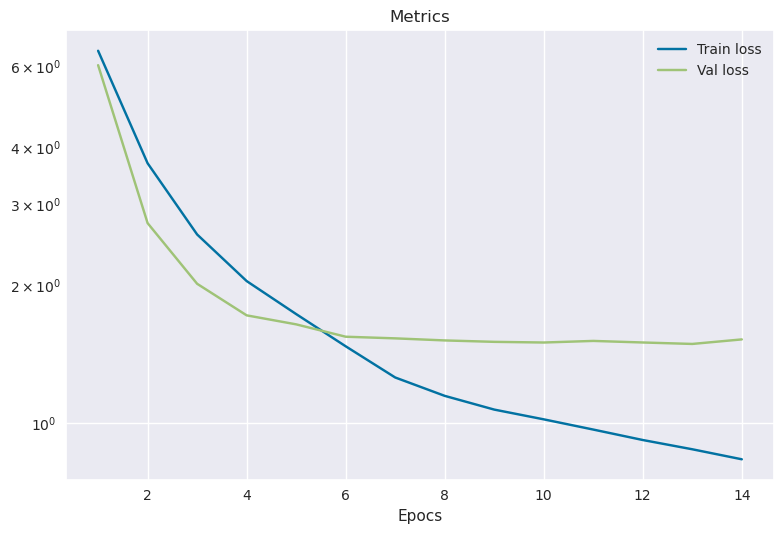

Computing metrics using validation set:   0%|          | 0/250 [00:00<?, ?it/s]

Ordered by mAP@5(4,5):


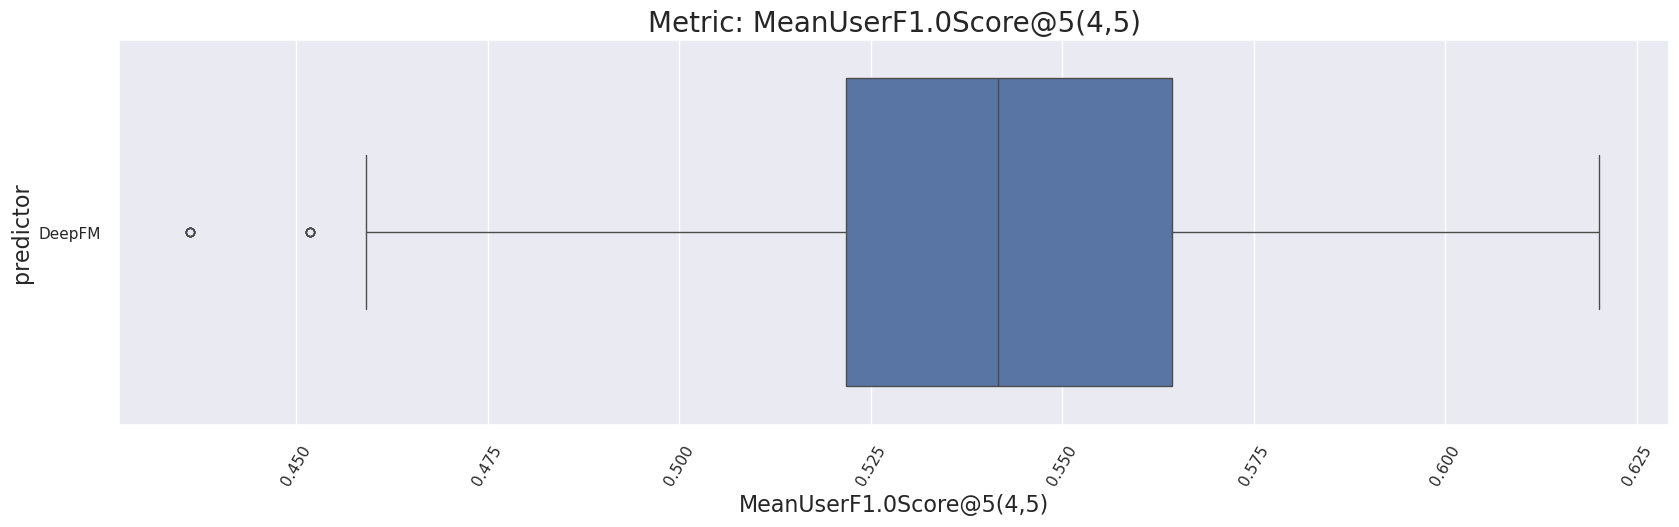

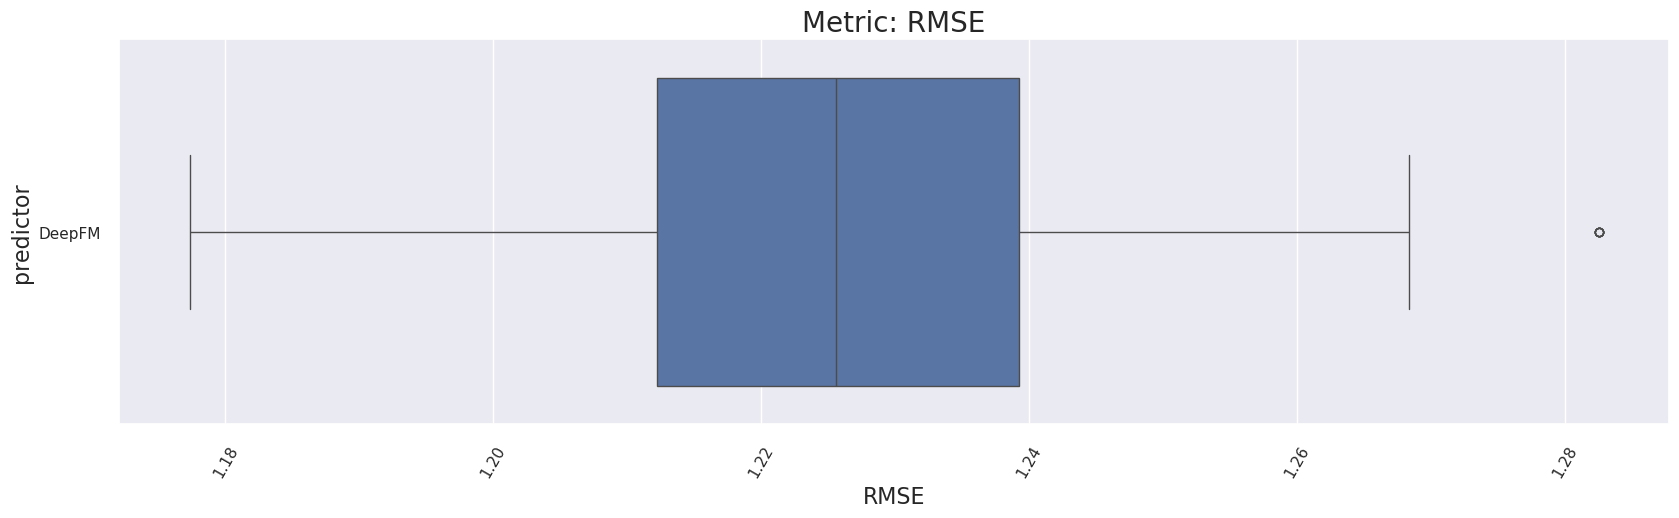

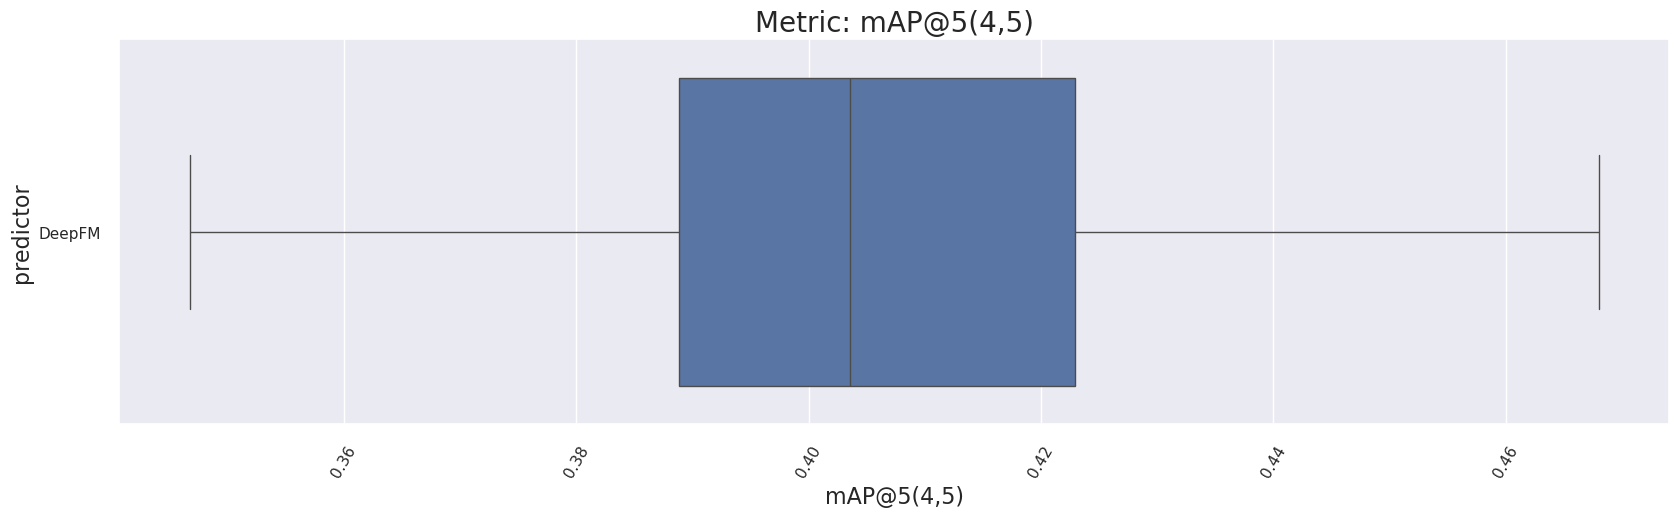

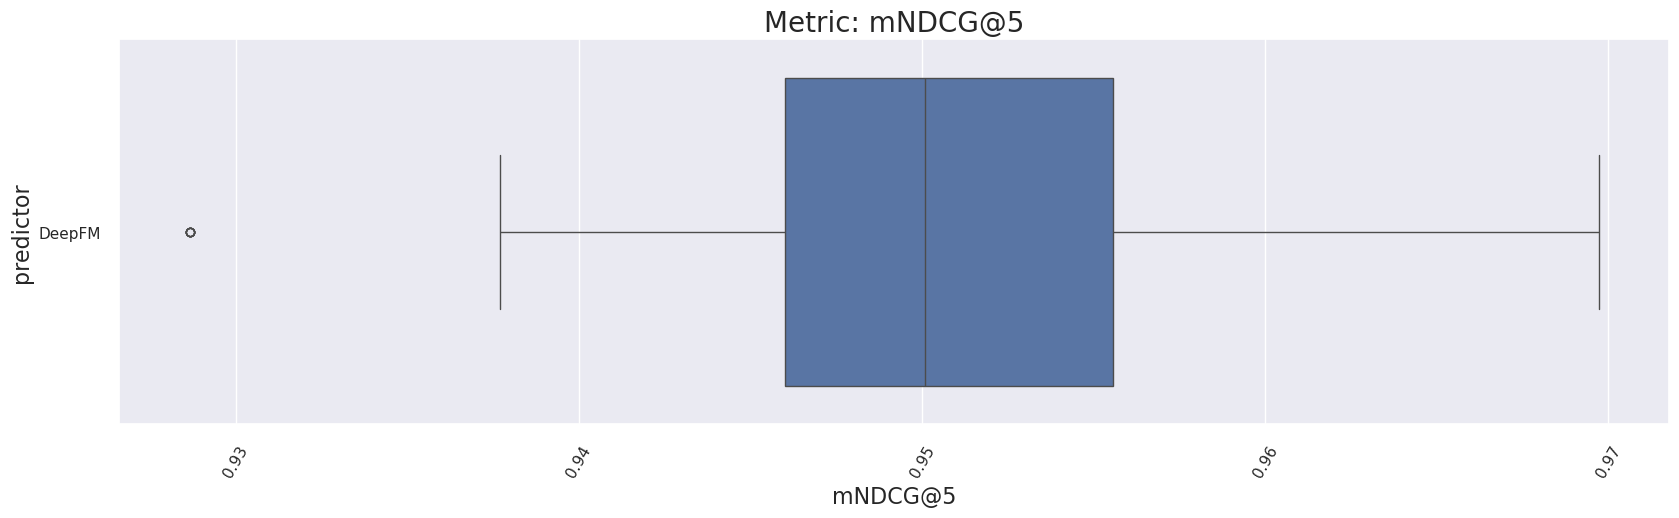

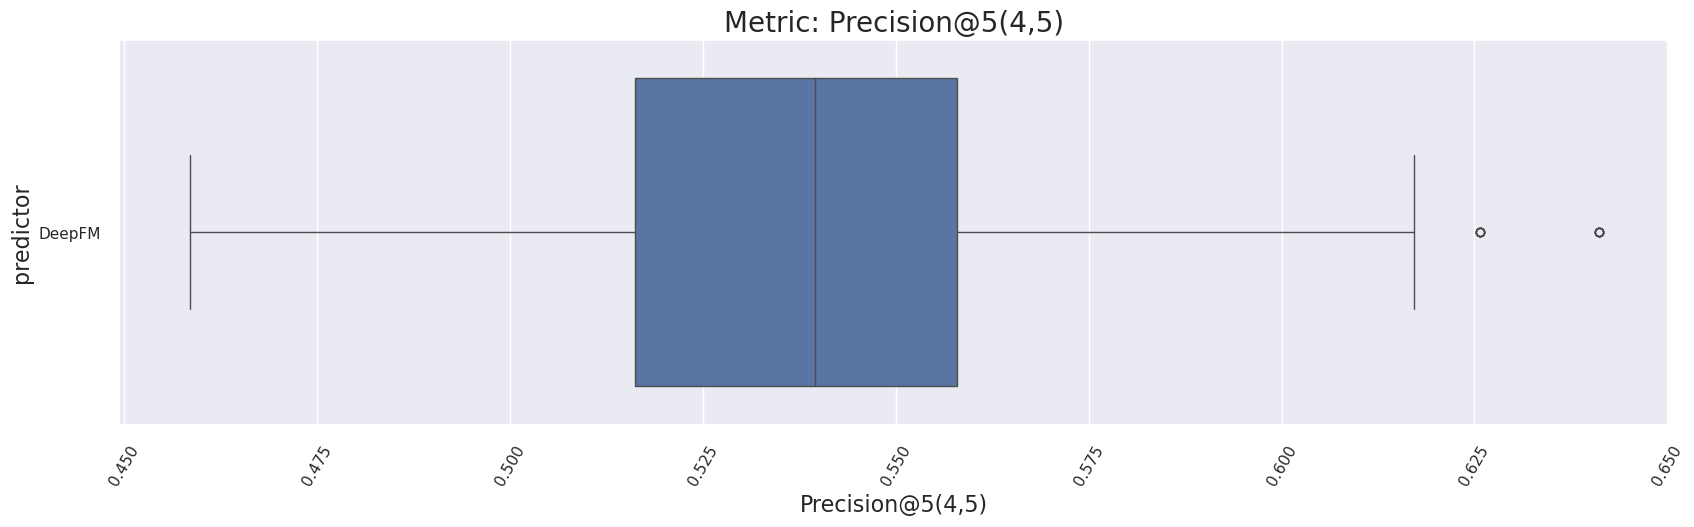

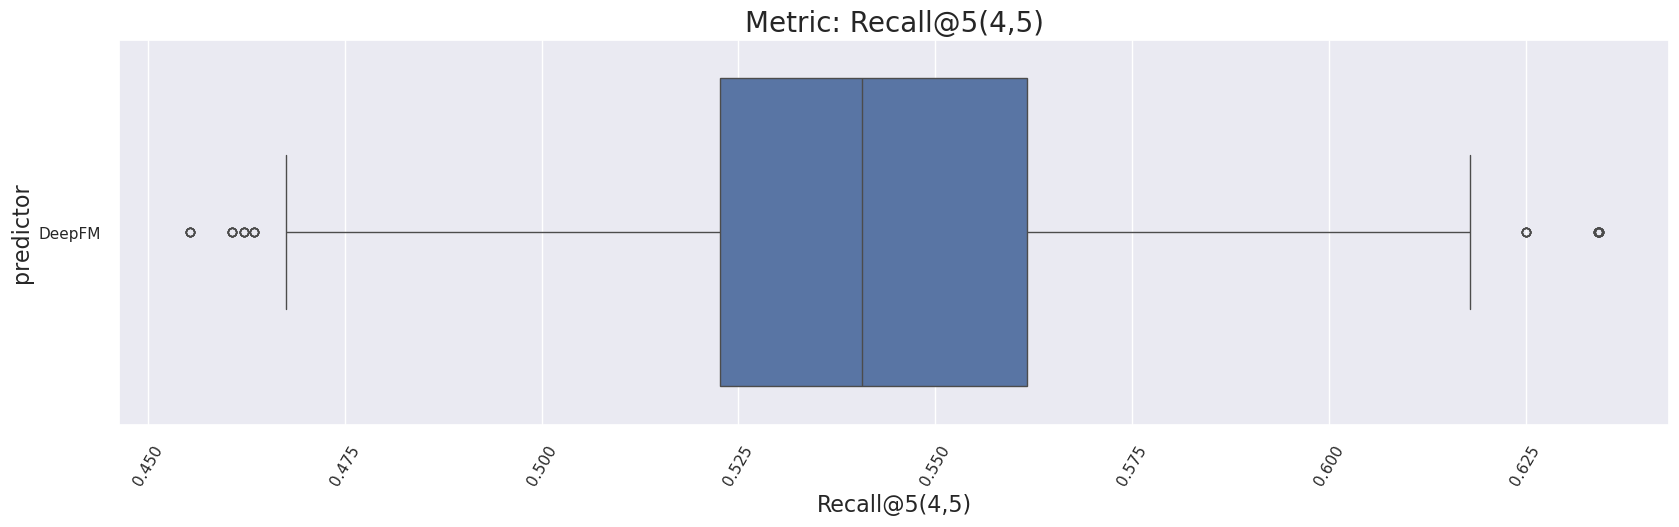

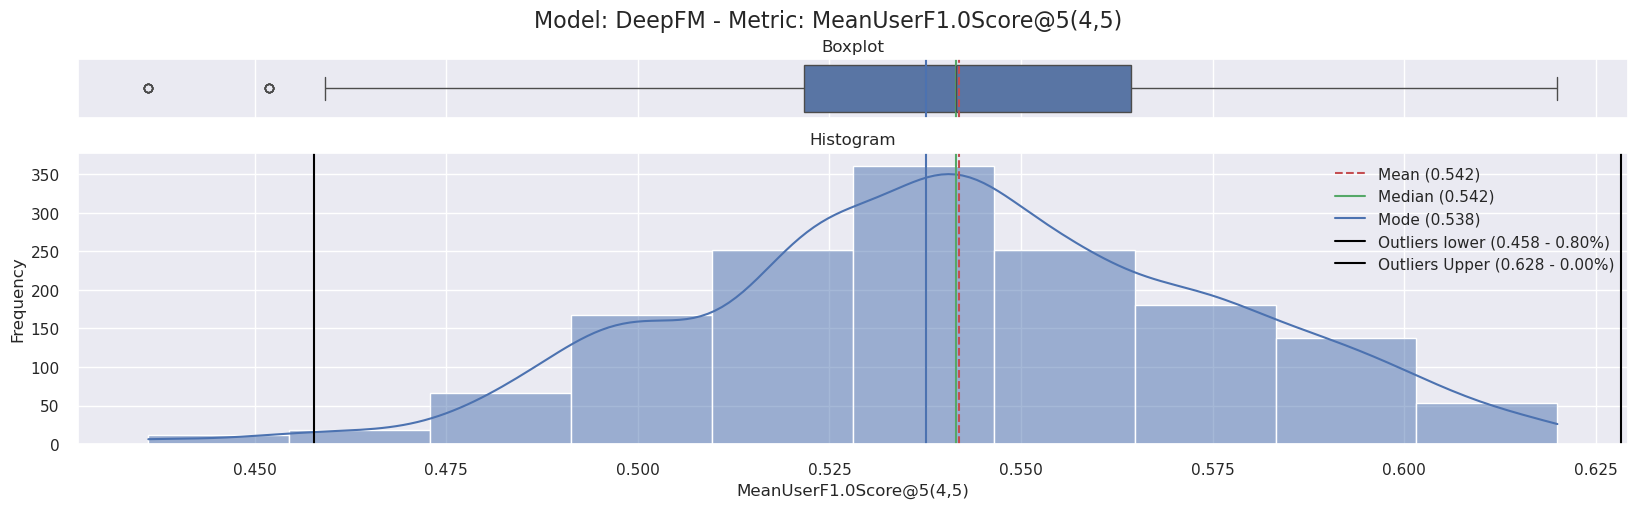

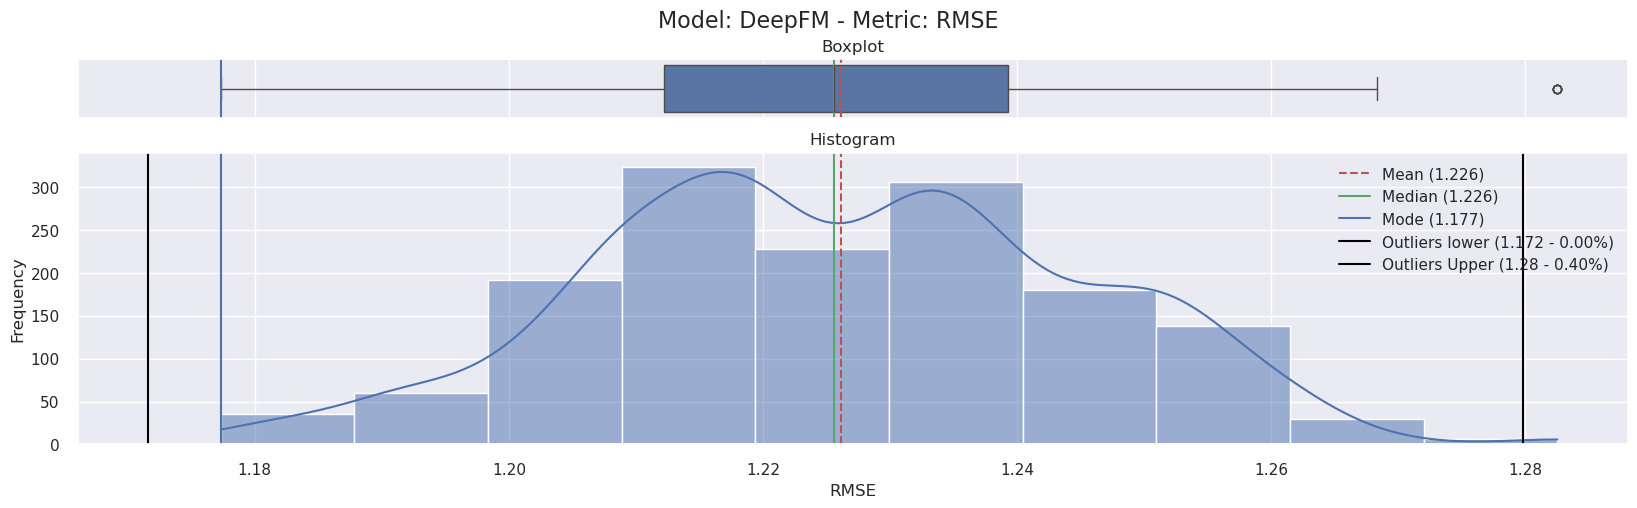

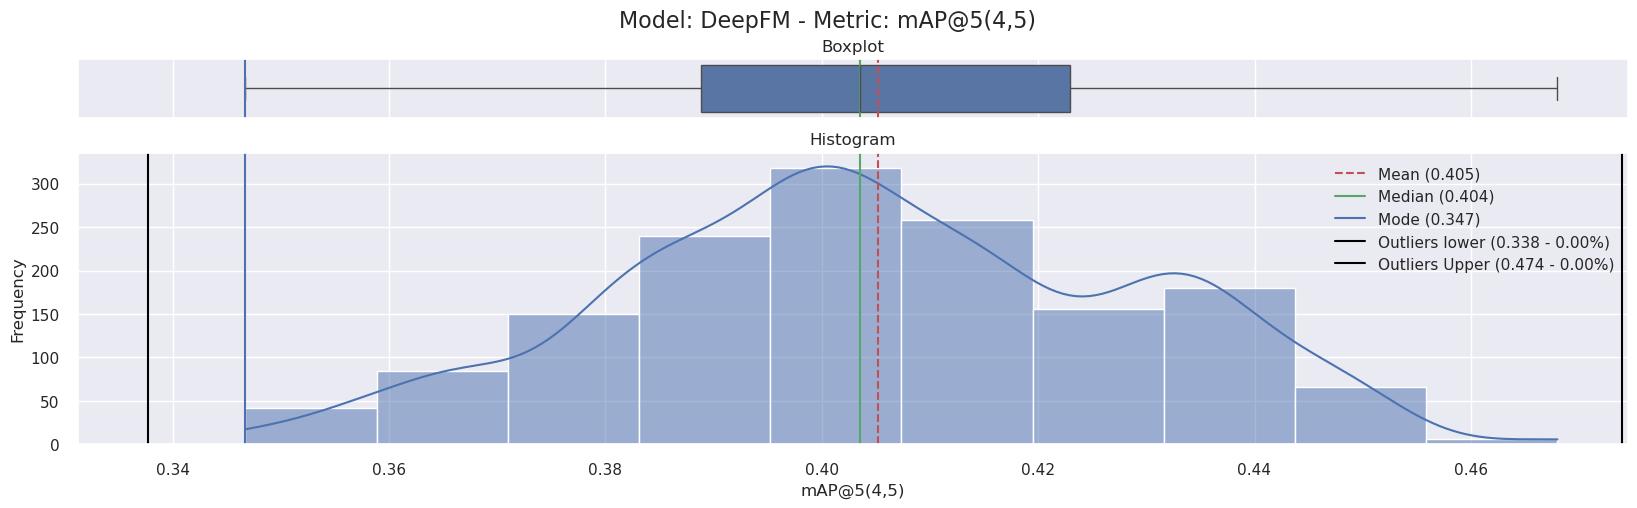

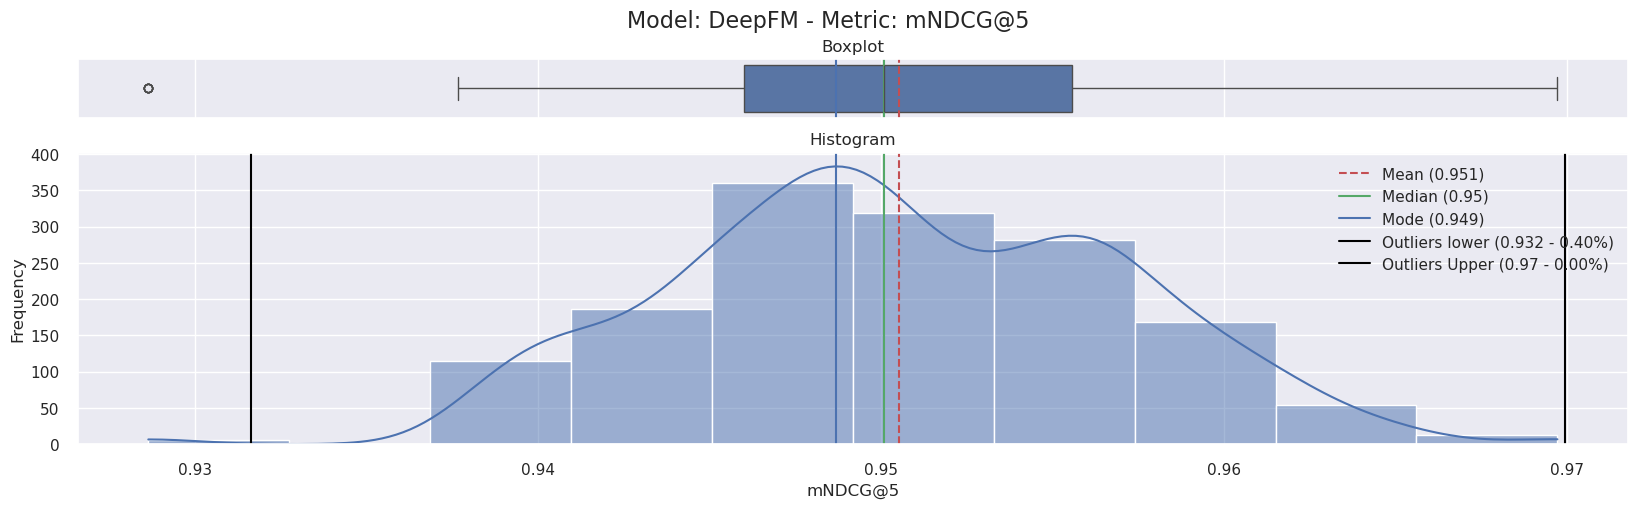

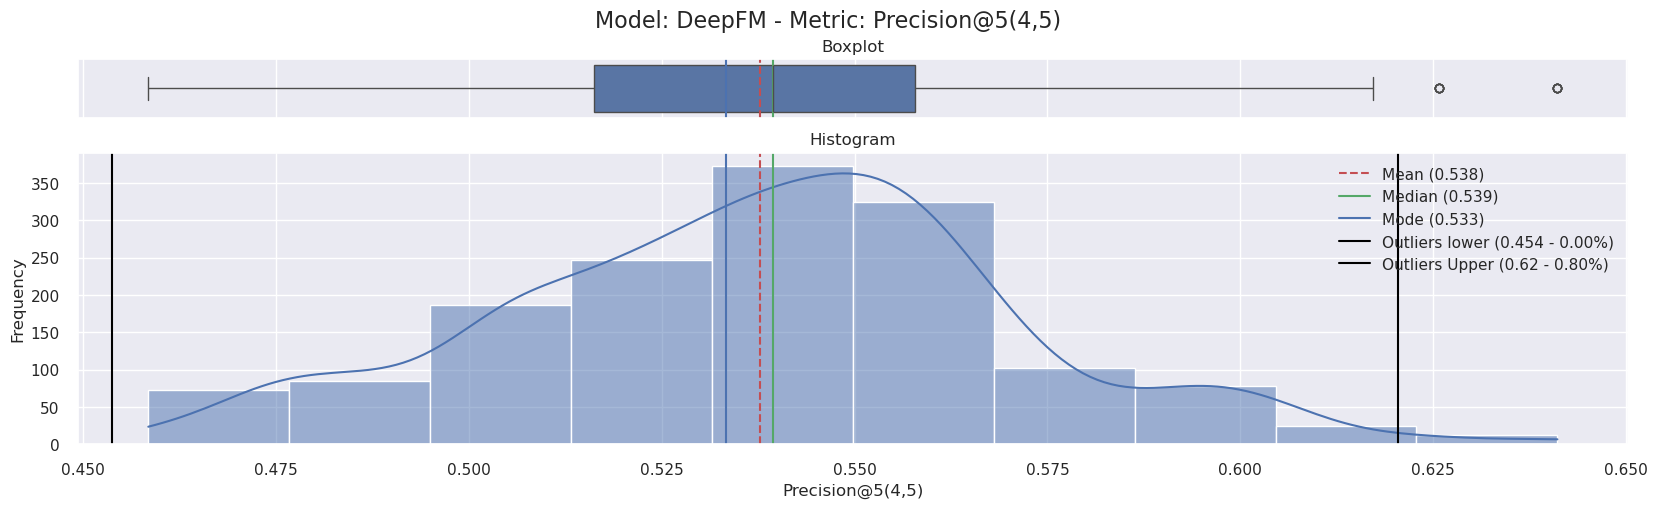

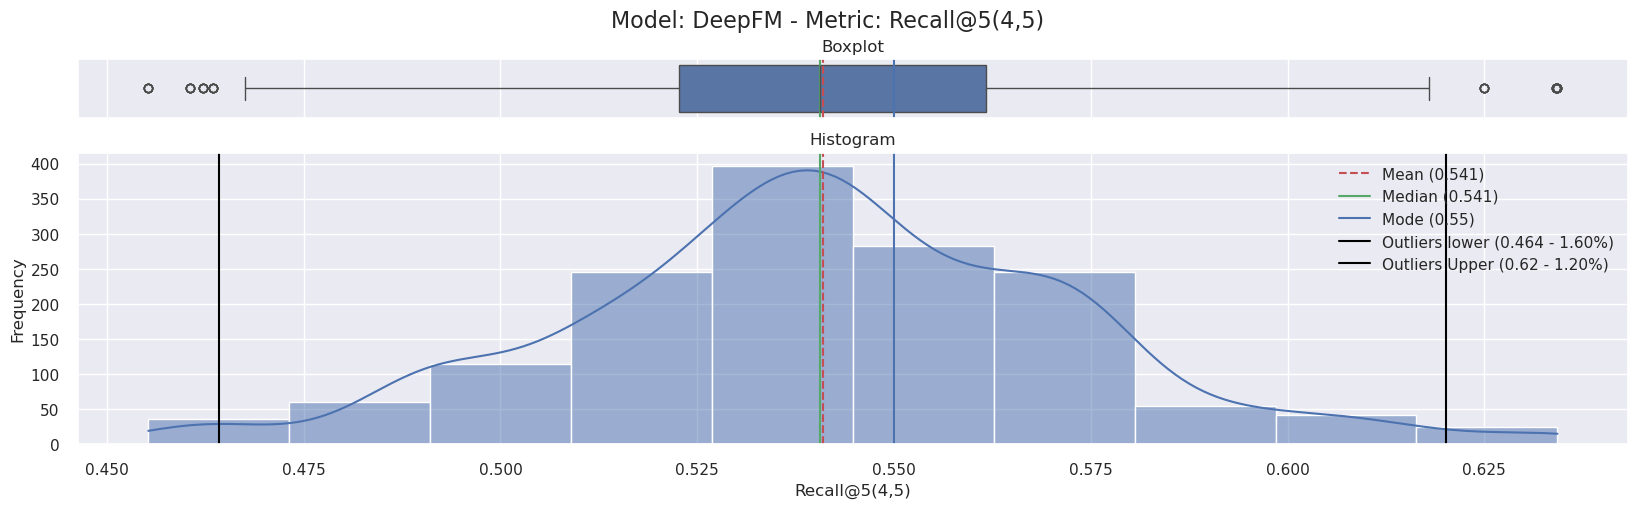

In [20]:
model, params = model_loader.load(train_set, test_set)

## Update users and items embeddings into chroma-db

This step updates the recommender chatbot database with user and item embeddings that exist only in the training set.

In [21]:
helper.update_embeddings(model, train_set)

Insert embeddings into "users_cf" collection (chroma-db):   0%|          | 0/1653 [00:00<?, ?it/s]

Insert embeddings into "items_cf" collection (chroma-db):   0%|          | 0/16873 [00:00<?, ?it/s]

## Simple item embeddings evaluation

In [22]:
similars_df = await similars('Toy Story', limit=14000)

Toy Story

### Toy Story distances distribution

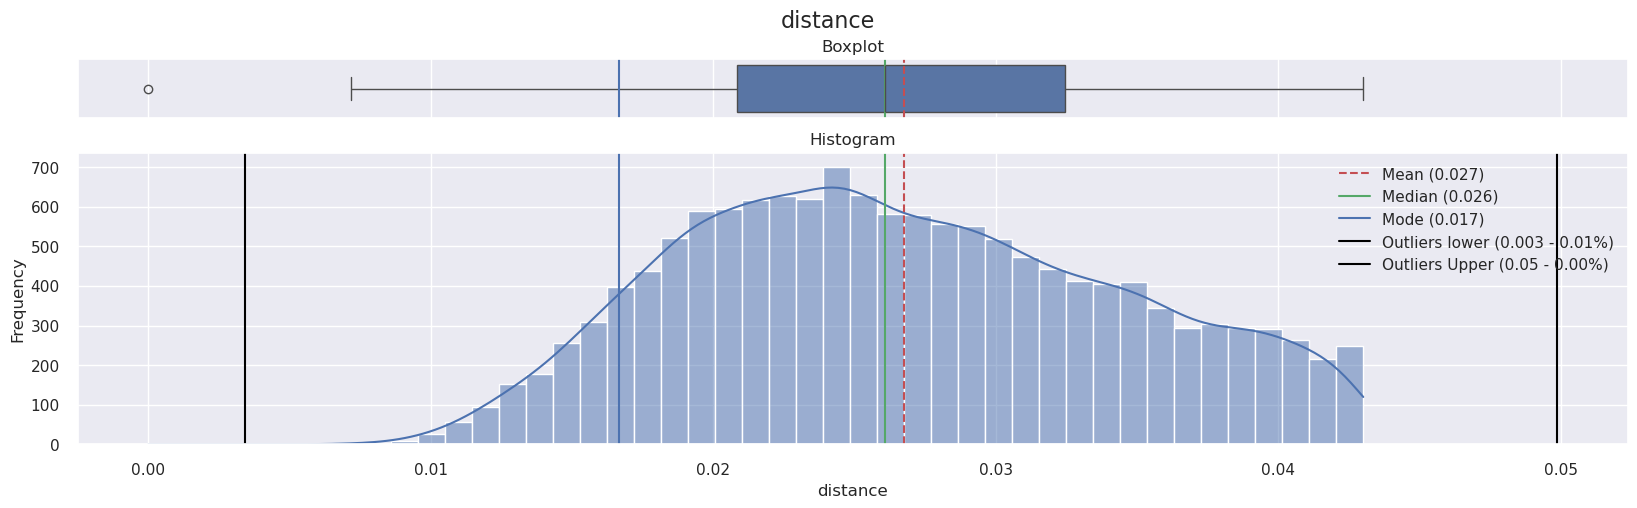

In [23]:
describe_num_var(similars_df, 'distance')

#### Observaciones

* Si visualizamos ls distribucion de distancias de todos los items al item en cuestión, se aprecia que es una distrubución sesgada a izquierda, es decir que los datos se concentran a izquierda.
* La moda es menor a la media dado que hay una concetracion de valores menos tipicos a derecha que empizan a al meda a derecha. La Moda se encuentra a la zquierca de la emdia ya que en ese sector se contrentra la mayor cantidad de valores.
* Esto no dice que hay mas items cercanos que lejanos. Esto item lejanos podemos verlos como valores atipicos, ya que el centro de la districion se encuentra mas cercano al item buscado.
* Observando la distribución de distancias, se pueden identificar:

    * **Sesgo a la izquierda**: La distribución está sesgada hacia la izquierda, lo que indica que la mayoría de las películas están relativamente cercanas en términos de distancia al item _Toy Story_. Esto sugiere que hay un gran número de películas que son similares a _Toy Story_ según las características del modelo que generó estas distancias.
    
    * **Medidas de tendencia central**
        * **Media**: La media de las distancias es 0.027, lo que está ligeramente más a la derecha del pico de la distribución. Esto se debe al sesgo de la distribución.
        * **Mediana**: La mediana (0.026) es muy cercana a la moda, lo que indica que más del 50% de los valores se encuentran alrededor del pico de la distribución.
        * **Moda**: La moda (0.017) es el valor más frecuente y está ubicado más a la izquierda, lo que coincide con la forma sesgada de la distribución.
        * **Outliers (Valores atípicos)**: Los outliers superiores están definidos a partir de un valor de 0.05, que es bastante alto en comparación con el rango de la mayoría de los datos. Esto indica que hay algunas películas que son significativamente diferentes a _Toy Story_.
        Los outliers inferiores parecen ser bastante cercanos a cero (alrededor de 0.003), indicando que hay algunos items extremadamente cercanos a "Toy Story" en términos de características o atributos, lo cual podría representar secuelas o películas muy similares en términos de género o audiencia.


* **Forma de la distribución**: La forma de la distribución sugiere una cola larga hacia la derecha, lo cual es típico de distribuciones que representan similitud o proximidad en espacios embebidos (embeddings). Esta cola larga puede contener items que son menos similares a _Toy Story_.
Interpretación del espacio de embeddings: La distribución muestra que la mayoría de los items en el dataset están relativamente cerca de _Toy Story_, lo que podría indicar que la representación del espacio embebido (embedding space) agrupa muchos items similares en términos de género o características compartidas (por ejemplo, películas de animación o dirigidas a una audiencia familiar).

* **Utilidad para recomendaciones**: Este tipo de distribución es útil para sistemas de recomendación porque permite identificar un umbral óptimo para definir **similitud**. Por ejemplo, podrías elegir un umbral justo antes de donde comienzan los valores atípicos superiores para asegurar recomendaciones de películas que son muy similares a _Toy Story_.

### Toy Story item  similarity with items with Animation, Adventure and Children genres

In [24]:
genres_similars_df = filter_by_geners(similars_df, ['animation', 'adventure', 'children'])
genres_similars_df.head()

,distance,rating,id,title,genres,release
0,0.000000,3.806931,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995
9813,0.009520,3.677419,5882,Treasure Planet,"[adventure, animation, children, sci-fi, imax]",2002
6132,0.012169,4.134615,2761,"Iron Giant, The","[adventure, animation, children, drama, sci-fi]",1999
1352,0.012388,3.400000,117851,Penguins of Madagascar,"[adventure, animation, children, comedy]",2014
8139,0.013001,3.600000,4519,"Land Before Time, The","[adventure, animation, children, fantasy]",1988


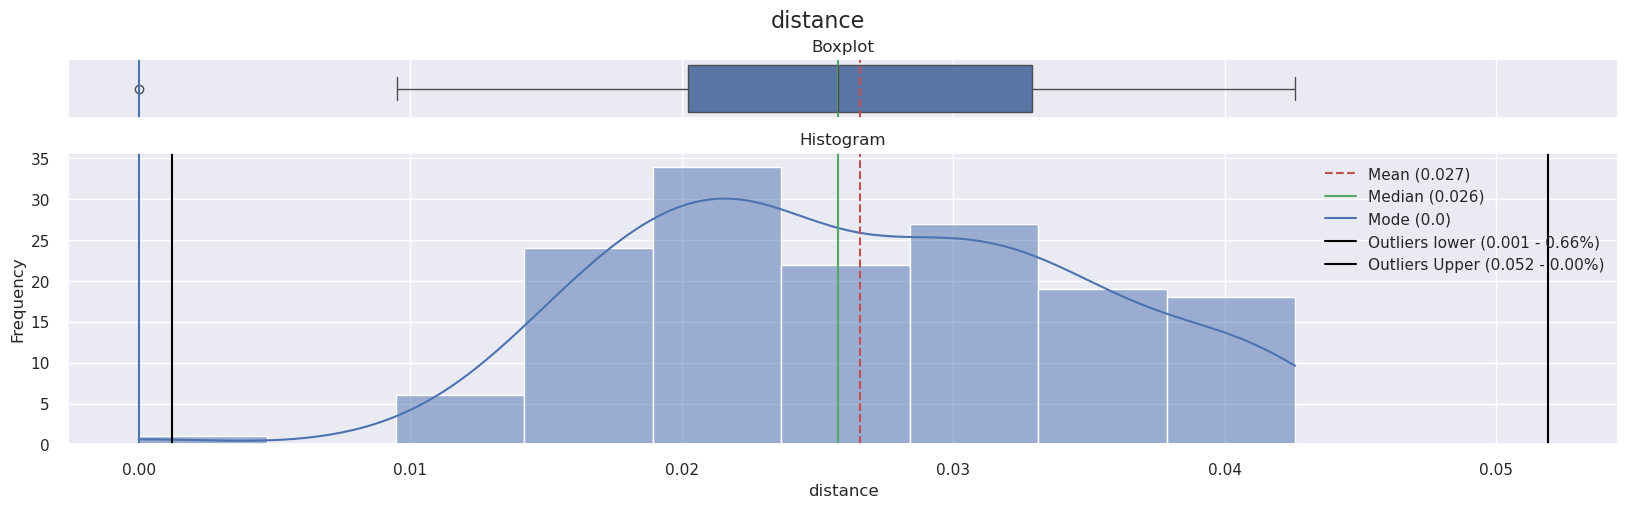

In [25]:
describe_num_var(genres_similars_df, 'distance')

### Observaciones


* **Subconjunto más Cercano a _Toy Story_**: Esta distribución representa un subconjunto de la distribución original, específicamente para las películas que pertenecen a los géneros _animation_, _adventure_ y _children_. Al ser un subconjunto más específico, es natural que las similitudes sean más altas (distancias más bajas), ya que estas películas comparten géneros clave con _Toy Story_.

* **Distribución de Distancias Más Concentrada**

    * La distribución tiene un claro pico alrededor de la distancia 0, lo que indica que muchas películas en este subconjunto son muy similares o incluso idénticas en términos de características clave a _Toy Story_. Esto sugiere que las películas de estos géneros tienden a agruparse más cerca en el espacio de embeddings.
    * Hay un segundo pico alrededor de 0.02, lo que indica que hay otro grupo de películas que, aunque no son idénticas, siguen siendo bastante similares a _Toy Story_.

* **Medidas de Tendencia Central**

    * **Media (0.027) y Mediana (0.026)**: Son casi idénticas a las de la distribución completa, lo que muestra que las películas dentro de estos géneros específicos aún están dentro de la misma gama general de similitud.
    * **Moda (0.0)**: La moda es 0, lo cual tiene sentido ya que incluye _Toy Story_ en la comparación consigo misma.

* **Comparación con la Distribución General**

    * **Menor Variabilidad**: En comparación con la distribución general, la variabilidad es menor aquí, lo que se puede ver en la menor cantidad de outliers y en la distribución más ajustada. Esto refleja que las películas de géneros específicos son más homogéneas en términos de similitud con _Toy Story_.
    * **Diferencias Menores**: Los valores de outliers superiores son similares (0.052 en ambos casos), lo que sugiere que incluso dentro de los géneros _animation_, _adventure_ y _children_, hay algunas películas que son significativamente diferentes de _Toy Story_.

* **Relevancia para Recomendaciones**

    * Esta distribución puede ser particularmente útil para sistemas de recomendación que buscan recomendar películas muy similares a _Toy Story_ dentro de los mismos géneros. Los picos en distancias bajas indican que hay muchas películas que son buenas candidatas para recomendaciones muy cercanas.
    * Las distancias ligeramente más altas pero aún dentro de este subconjunto (como el segundo pico alrededor de 0.02) podrían representar películas que son similares pero con alguna variación que podría ser interesante para un espectador que busca algo un poco diferente pero en la misma línea general.


### Terminator distances distribution

Toy Story

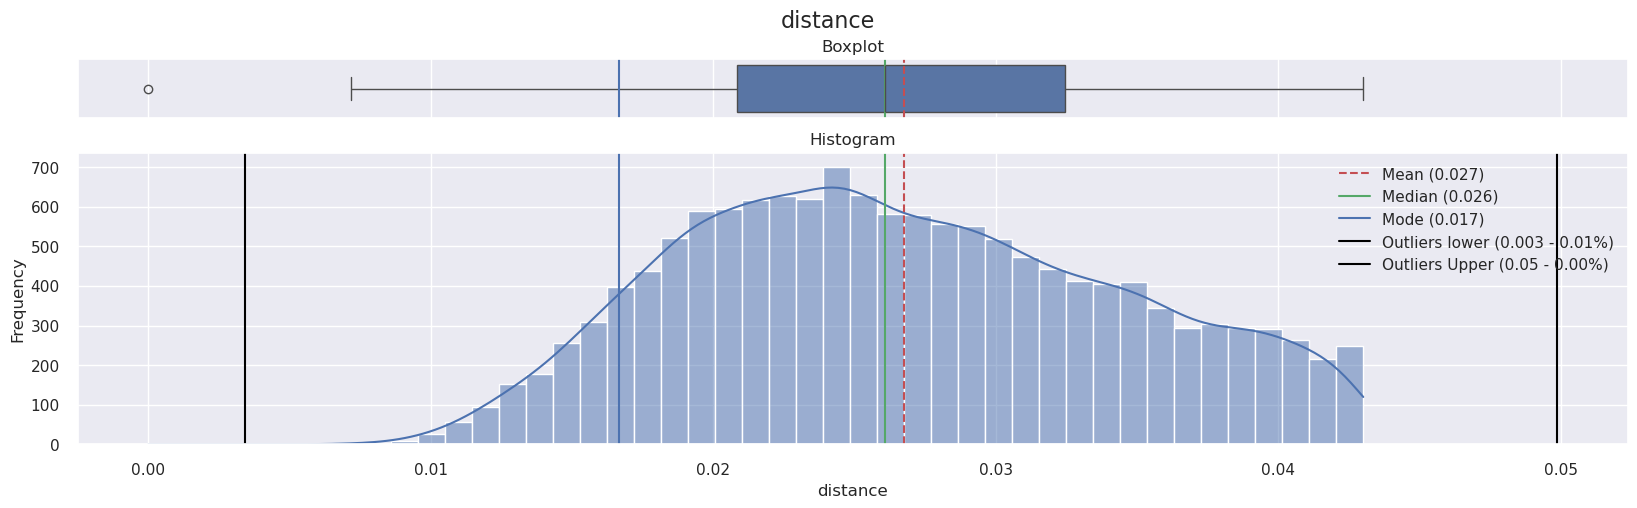

In [26]:
similars_df2 = await similars('Terminator', limit=14000)

describe_num_var(similars_df2, 'distance')

### Observaciones

* La distribución general de distancias muestra un sesgo a la izquierda, con una concentración de distancias más bajas. Esto indica que la mayoría de los ítems (películas) tienen una similitud moderada a alta con _Terminator_.
* La cola de la distribución se extiende hacia la derecha, sugiriendo que también hay películas que son significativamente diferentes de _Terminator_.

* **Medidas de Tendencia Central**
  * **Media (0.027) y Mediana (0.026)**: Estos valores son bastante bajos, indicando que, en promedio, las películas en este conjunto tienen una similitud razonable con _Terminator_.
  * **Moda (0.017)**: Es relativamente bajo, lo que sugiere que la mayor parte de las películas están agrupadas en un rango de similitud cercano.

* **Outliers y Rango de Distancias**
  * La gráfica muestra algunos outliers con distancias más bajas y más altas. Esto indica la presencia de algunas películas que son muy similares a _Terminator_ y otras que son considerablemente diferentes.
  * El rango de outliers superiores se extiende hasta aproximadamente 0.05, lo que sugiere que hay algunas películas que son bastante disímiles.

### Terminator item similarity with items with Action, Adventure, Sci-Fi and Thriller genres

In [27]:
genres_similars_df2 = filter_by_geners(similars_df2, ['action', 'adventure', 'sci-fi', 'thriller'])
genres_similars_df2.head()

,distance,rating,id,title,genres,release
8581,0.010356,3.891626,48774,Children of Men,"[action, adventure, drama, sci-fi, thriller]",2006
2388,0.010745,3.705882,1356,Star Trek: First Contact,"[action, adventure, sci-fi, thriller]",1996
7284,0.013130,3.625000,3703,"Road Warrior, The","[action, adventure, sci-fi, thriller]",1981
1620,0.014634,3.862832,122882,Mad Max: Fury Road,"[action, adventure, sci-fi, thriller]",2015
10351,0.017315,3.568627,6333,X2: X-Men United,"[action, adventure, sci-fi, thriller]",2003


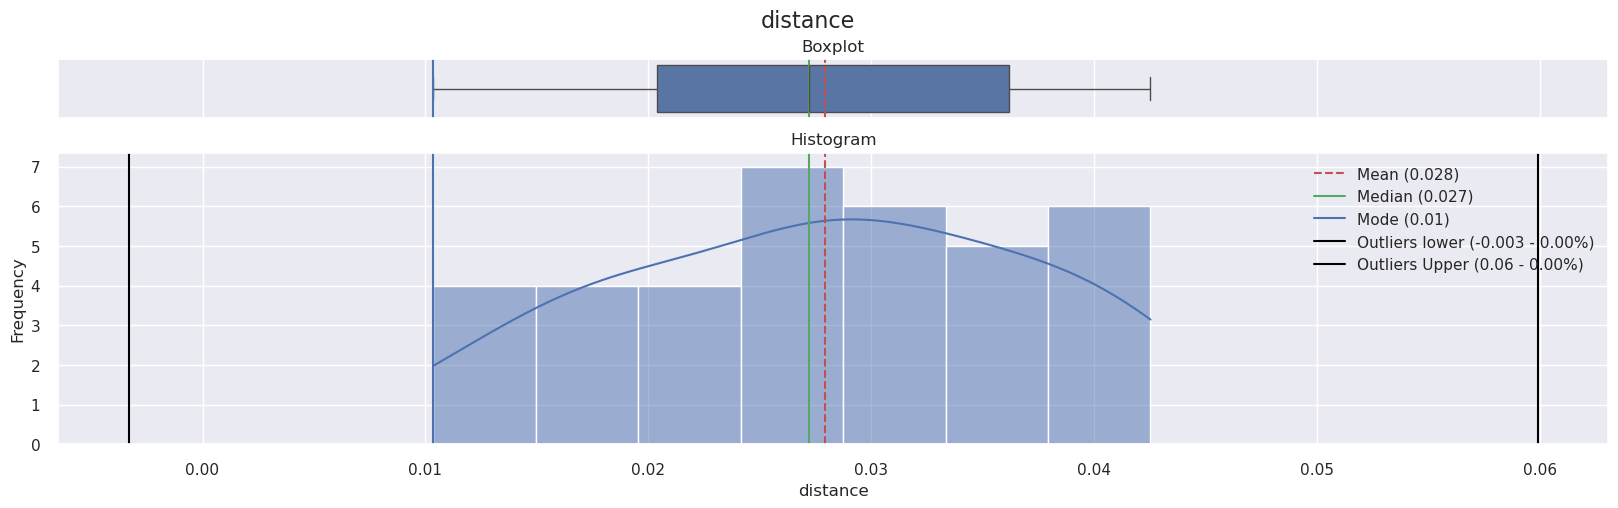

In [28]:
describe_num_var(genres_similars_df2, 'distance')

#### Observaciones

La distribución muestra las distancias para películas de géneros específicos: Action, Adventure", "sci-fi", y "thriller". Esto es un subconjunto más específico de la distribución general, enfocado en géneros más relevantes para "Terminator".

* **Concentración de Películas Muy Similares**

    * Se observa una mayor concentración de películas con distancias más bajas (alrededor de 0.01), lo cual es esperado ya que estos géneros están más alineados con el contenido y estilo de "Terminator".
    * Hay un pico en distancias cercanas a 0, lo que indica la existencia de películas muy similares dentro de estos géneros.

* **Medidas de Tendencia Central Ajustadas**

    * **Media (0.028) y Mediana (0.027)**: Son ligeramente más altas que las de la distribución general, lo que podría indicar que, dentro de los géneros seleccionados, las películas tienden a tener una similitud menos extrema pero aún relevante con "Terminator".
    * **Moda (0.01)**: Similar a la distribución general, indicando una similitud alta para muchas películas dentro de los géneros específicos.


* **Variabilidad Menor en el Subconjunto**: Menor cantidad de outliers en comparación con la distribución general, lo que sugiere una mayor homogeneidad en términos de similitud entre "Terminator" y otras películas de los géneros seleccionados.

* **Rango de Outliers Superiores**: El rango de outliers superiores es un poco más amplio que en la distribución general (hasta 0.06), lo que puede indicar que dentro de los géneros "action", "adventure", "sci-fi", y "thriller" hay algunas películas que son bastante diferentes de "Terminator".

#### Conclusiones Generales

* **Similitud Alta Dentro de Géneros Relevantes**: Filtrar por géneros específicos permite identificar más claramente las películas que son más similares a "Terminator". Esto es útil para recomendaciones de contenido más precisas y dirigidas.

* **Diversidad en Películas Similares**: Aunque las películas dentro de los géneros específicos tienden a ser más similares entre sí, sigue habiendo una diversidad de similitudes (variabilidad), especialmente hacia los outliers superiores, lo que sugiere que hay espacio para variedad incluso dentro de películas del mismo género.

* **Implicaciones para Recomendaciones**: Las distribuciones muestran que se pueden hacer recomendaciones precisas basadas en similitud dentro de un género específico, mientras que también se deja espacio para sugerencias más variadas cuando se considera la distribución general.

## Upsert predicted interactions


In [33]:
await helper.update_database(train_set, model)